In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.preprocessing import MinMaxScaler
import datetime

In [33]:
# !curl https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv  -o ../data/raw/counties_06-19.csv
# !curl https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/deaths_timeseries.csv -o ../data/raw/time_series_covid19_deaths_US_06-19.csv
# !curl https://opendata.arcgis.com/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D -o ../data/raw/hospitals.csv
# !curl https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50.csv -o ../data/raw/DL-us-m50.csv
# !curl https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50_index.csv -o ../data/raw/DL-us-m50_index.csv
# !curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv -o ../data/raw/time_series_covid19_deaths_US_05-22.csv
# !curl https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=694ae9957380f150 -o ../data/raw/google_mobility_report_06-14-20.csv
!curl https://raw.githubusercontent.com/HopkinsIDD/hit-covid/master/data/hit-covid-longdata.csv -o ../data/raw/hit_covid_interventions_06-26-20.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5249k  100 5249k    0     0  4408k      0  0:00:01  0:00:01 --:--:-- 4408k


## Pull Hospital Data

In [3]:
# Created by Michael
hospitals = pd.read_csv('../data/raw/hospitals.csv')[['TYPE', 'STATUS', 'COUNTYFIPS', 'BEDS']]
hospitals = hospitals[hospitals["STATUS"] == 'OPEN']
hospitals = hospitals[hospitals["TYPE"] == 'GENERAL ACUTE CARE']
hospitals = hospitals[hospitals["BEDS"].astype(str).astype(int) > 0]
hospitals["FIPS"] = hospitals["COUNTYFIPS"]
hospitals = hospitals[hospitals["FIPS"] != 'NOT AVAILABLE']
hospitals = hospitals.drop(["COUNTYFIPS", "STATUS"], axis=1)
hospitals["FIPS"] = hospitals["FIPS"].astype(str).astype(int)
fips_groups = hospitals.groupby("FIPS")

hosp_data = pd.DataFrame(columns=['FIPS', 'HospCt', 'Beds'])
for fips_code, grp in fips_groups:
    hosp_data = hosp_data.append({'FIPS': fips_code, 'HospCt': len(grp), 'Beds': sum(grp["BEDS"])}, ignore_index=True)   

hosp_data.head()

,FIPS,HospCt,Beds
0,1001,1,85
1,1003,3,332
2,1005,1,74
3,1007,1,35
4,1011,1,61


## County Data

In [4]:
counties = pd.read_csv('../data/raw/counties_06-19.csv')
# print(counties.columns.values)
counties = counties.dropna(how='any')
# counties['FIPS'] = counties['FIPS'] .astype('int')
counties = counties.set_index('FIPS')
# print(counties.where(counties['FIPS'] == 36061))
print(counties.loc[6037,], '\n')
# counties = counties.filter(['FIPS', 'Rural-urban_Continuum Code_2013', 'Density per square mile of land area - Population'])
counties = counties.filter(['FIPS',  'Density per square mile of land area - Population', 'Rural-urban_Continuum Code_2013', \
                            'Percent of adults with less than a high school diploma 2014-18',\
                            "Percent of adults with a bachelor's degree or higher 2014-18", 'Unemployment_rate_2018', \
                            'Med_HH_Income_Percent_of_State_Total_2018', 'Jan Temp AVG / F', 'Feb Temp AVG / F', 'Mar Temp AVG / F', 'Apr Temp AVG / F', 'May Temp AVG / F', \
                            'Jun Temp AVG / F', 'Jul Temp AVG / F', 'Aug Temp AVG / F', 'Sep Temp AVG / F', 'Oct Temp AVG / F', 'Nov Temp AVG / F', 'Dec Temp AVG / F', 'Total_age65plus',  'Total households!!Average household size',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school', 'POP_ESTIMATE_2018', \
                            'H_MALE', 'H_FEMALE', 'BA_MALE', 'BA_FEMALE'])
counties = counties.dropna()
counties = counties.merge(hosp_data, left_on='FIPS', right_on='FIPS')
counties['Hispanic Population'] = counties['H_MALE'] + counties['H_FEMALE']
counties = counties.drop(columns=['H_FEMALE', 'H_MALE'])
counties['Black Population'] = counties['BA_MALE'] + counties['BA_FEMALE']
counties = counties.drop(columns=['BA_FEMALE', 'BA_MALE'])
counties.head()

State                                              CA
Area_Name                          Los Angeles County
Rural-urban_Continuum Code_2013                     1
Urban_Influence_Code_2013                           1
Economic_typology_2015                              0
                                          ...        
Number of AGGRAVATED ASSAULTS                   23057
BURGLRY                                         49107
LARCENY                                        142604
MOTOR VEHICLE THEFTS                            40555
ARSON                                            2210
Name: 6037, Length: 346, dtype: object 



,FIPS,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Beds,Hispanic Population,Black Population
0,1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,...,3065.0,1449.0,23254.0,11209.0,6503.0,218022,3,332,10131.0,19492.0
1,1015,195.7,3.0,15.9,18.0,4.7,91.0,44.2,52.6,53.0,...,1563.0,1484.0,11224.0,4972.0,6890.0,114277,3,552,4469.0,24153.0
2,1043,109.4,4.0,18.2,13.7,3.3,91.8,43.2,51.8,51.2,...,734.0,547.0,8867.0,4571.0,3024.0,83442,1,145,3699.0,1116.0
3,1049,91.5,6.0,25.9,12.7,3.8,79.2,41.5,49.9,49.8,...,386.0,700.0,8313.0,4354.0,1654.0,71385,1,134,10595.0,1325.0
4,1051,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,...,1057.0,546.0,7403.0,5128.0,4022.0,81887,2,138,2467.0,17570.0


## Deaths Data

In [5]:
deaths_t_series = pd.read_csv('../data/raw/time_series_covid19_deaths_US_06-19.csv')
# print(filtered.loc[36061,])
# print(deaths.columns.values)
# deaths_t_series = deaths_t_series.drop(['UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Population', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis=1)
deaths_t_series = deaths_t_series.drop(['Combined_Key'], axis=1)

# deaths = deaths.dropna()
# deaths = deaths.set_index('FIPS')

deaths_t_series.head()

,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20
0,1001,0,0,0,0,0,0,0,0,0,...,5,5,5,5,6,6,6,6,6,6
1,1003,0,0,0,0,0,0,0,0,0,...,9,9,9,9,9,9,9,9,9,9
2,1005,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1007,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,1009,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [6]:
# total_deaths = pd.DataFrame(deaths.sum(axis=1), columns=['deaths'])
# total_deaths.columns = ['FIPS', 'deaths']
death_data = pd.DataFrame(columns=['FIPS', 'Deaths', 'Outbreak_date'])
dates = deaths_t_series.columns[1:]
death_thresh = 5
n_days = 21

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_t_series)):
    county = deaths_t_series.iloc[i]
    outbreak_date = None

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(dates)):
        if county[dates[j]] >= death_thresh: 
            outbreak_date = dates[j]

            # See if this happened n_days or more before current day
            try:
                n_days_later = dates[j+n_days]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later], 'Outbreak_date':outbreak_date}, ignore_index=True)
                break

            except:
                break
                
death_data.head()

,FIPS,Deaths,Outbreak_date
0,1003,9,5/5/20
1,1013,17,5/9/20
2,1017,17,4/3/20
3,1051,9,5/13/20
4,1055,10,4/10/20


In [7]:
combined_data = counties.merge(death_data, left_on='FIPS', right_on='FIPS')
combined_data = combined_data.dropna()
combined_data.set_index('FIPS', inplace=True)
combined_data.head()

,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Beds,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,66.0,...,23254.0,11209.0,6503.0,218022,3,332,10131.0,19492.0,9,5/5/20
1051,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,64.4,...,7403.0,5128.0,4022.0,81887,2,138,2467.0,17570.0,9,5/13/20
1055,195.2,3.0,15.5,17.7,4.1,90.0,43.9,51.5,52.2,62.8,...,10215.0,4628.0,4019.0,102501,2,627,4116.0,16094.0,10,4/10/20
1073,592.5,1.0,10.3,32.4,3.7,110.3,44.1,53.7,53.2,63.1,...,66358.0,32041.0,42212.0,659300,9,3866,26246.0,286501.0,33,4/3/20
1081,230.8,3.0,9.5,34.1,3.6,98.1,47.0,56.3,55.2,63.6,...,16416.0,8227.0,28826.0,163941,1,314,6164.0,37852.0,25,4/7/20


## Drop Outlier Counties

In [8]:
# combined_data = combined_data.drop(index=36061)
# combined_data = combined_data.drop(index=17031)
# combined_data = combined_data.drop(index=26163)
# combined_data = combined_data.drop(index=36059)
# combined_data = combined_data.drop(index=6037)
# combined_data = combined_data.drop(index=34013)
#36061(NY) 17031, 26163, 36059, 6037 (LA)
# combined_data.rename(columns={'Rural-urban_Continuum Code_2013': 'RUCC'}, inplace=True)
print(np.max(combined_data['Rural-urban_Continuum Code_2013']))
print(np.min(combined_data['Rural-urban_Continuum Code_2013']))
filter_high = combined_data['Rural-urban_Continuum Code_2013'] > 8
inidices_high = combined_data.where(filter_high).dropna().index.to_numpy()
filter_low = combined_data['Rural-urban_Continuum Code_2013'] < 0
inidices_low = combined_data.where(filter_low).dropna().index.to_numpy()
# print(filter.index.to_numpy().shape)
combined_data = combined_data.drop(index=inidices_low, axis=0)
combined_data = combined_data.drop(index=inidices_high, axis=0)
combined_data = combined_data.drop(columns=['Beds'])
# combined_data.set_index('FIPS', inplace=True)
combined_data.head()

6.0
1.0


,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,66.0,...,1449.0,23254.0,11209.0,6503.0,218022,3,10131.0,19492.0,9,5/5/20
1051,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,64.4,...,546.0,7403.0,5128.0,4022.0,81887,2,2467.0,17570.0,9,5/13/20
1055,195.2,3.0,15.5,17.7,4.1,90.0,43.9,51.5,52.2,62.8,...,1299.0,10215.0,4628.0,4019.0,102501,2,4116.0,16094.0,10,4/10/20
1073,592.5,1.0,10.3,32.4,3.7,110.3,44.1,53.7,53.2,63.1,...,8847.0,66358.0,32041.0,42212.0,659300,9,26246.0,286501.0,33,4/3/20
1081,230.8,3.0,9.5,34.1,3.6,98.1,47.0,56.3,55.2,63.6,...,1152.0,16416.0,8227.0,28826.0,163941,1,6164.0,37852.0,25,4/7/20


In [9]:
combined_data.head()

,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,66.0,...,1449.0,23254.0,11209.0,6503.0,218022,3,10131.0,19492.0,9,5/5/20
1051,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,64.4,...,546.0,7403.0,5128.0,4022.0,81887,2,2467.0,17570.0,9,5/13/20
1055,195.2,3.0,15.5,17.7,4.1,90.0,43.9,51.5,52.2,62.8,...,1299.0,10215.0,4628.0,4019.0,102501,2,4116.0,16094.0,10,4/10/20
1073,592.5,1.0,10.3,32.4,3.7,110.3,44.1,53.7,53.2,63.1,...,8847.0,66358.0,32041.0,42212.0,659300,9,26246.0,286501.0,33,4/3/20
1081,230.8,3.0,9.5,34.1,3.6,98.1,47.0,56.3,55.2,63.6,...,1152.0,16416.0,8227.0,28826.0,163941,1,6164.0,37852.0,25,4/7/20


## Mobility Data

In [10]:
dl_index = pd.read_csv('../data/raw/DL-us-m50_index_05-22.csv')
dl_abs_movement = pd.read_csv('../data/raw/DL-us-m50_05-22.csv')
dl_index = dl_index.dropna()
dl_abs_movement = dl_abs_movement.dropna()
dl = dl_index.merge(dl_abs_movement, on='fips')
print(dl.head())

baseline1 = pd.DataFrame(dl['2020-03-01_y'] / (.01 * dl['2020-03-01_x']))
baseline2 = pd.DataFrame(dl['2020-03-02_y'] / (.01 * dl['2020-03-02_x']))
baseline3 = pd.DataFrame(dl['2020-03-03_y'] / (.01 * dl['2020-03-03_x']))
baselines = pd.concat((baseline1, baseline2, baseline3), axis=1)

pd.set_option('display.max_rows', None)
dl['baseline m50 mobility'] = baselines.mean(axis=1)
baseline_data = dl[['baseline m50 mobility', 'fips']]
baseline_data['FIPS'] = baseline_data['fips']
baseline_data = baseline_data.drop(['fips'], axis=1)
baseline_data.set_index('FIPS', inplace=True)
baseline_data.head()

  country_code_x  admin_level_x admin1_x        admin2_x    fips  \
0             US              2  Alabama  Autauga County  1001.0   
1             US              2  Alabama  Baldwin County  1003.0   
2             US              2  Alabama  Barbour County  1005.0   
3             US              2  Alabama     Bibb County  1007.0   
4             US              2  Alabama   Blount County  1009.0   

   2020-03-01_x  2020-03-02_x  2020-03-03_x  2020-03-04_x  2020-03-05_x  ...  \
0          49.0         100.0          95.0          95.0         100.0  ...   
1          81.0         100.0          95.0          90.0         102.0  ...   
2          90.0         107.0         100.0          70.0          88.0  ...   
3          53.0          95.0         100.0          94.0         111.0  ...   
4          68.0          96.0         100.0          99.0         101.0  ...   

   2020-05-10_y  2020-05-11_y  2020-05-12_y  2020-05-13_y  2020-05-14_y  \
0         5.914         8.067      

/Users/beatrizmedeiros/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,baseline m50 mobility
FIPS,
1001.0,14.621123
1003.0,12.067112
1005.0,9.297363
1007.0,24.332641
1009.0,23.362889


In [11]:
combined_data = baseline_data.merge(combined_data, left_on='FIPS', right_on='FIPS')
combined_data.head(50)

,baseline m50 mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,
1003.0,12.067112,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,...,1449.0,23254.0,11209.0,6503.0,218022,3,10131.0,19492.0,9,5/5/20
1051.0,15.867430,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,...,546.0,7403.0,5128.0,4022.0,81887,2,2467.0,17570.0,9,5/13/20
1055.0,9.411457,195.2,3.0,15.5,17.7,4.1,90.0,43.9,51.5,52.2,...,1299.0,10215.0,4628.0,4019.0,102501,2,4116.0,16094.0,10,4/10/20
1073.0,9.981023,592.5,1.0,10.3,32.4,3.7,110.3,44.1,53.7,53.2,...,8847.0,66358.0,32041.0,42212.0,659300,9,26246.0,286501.0,33,4/3/20
1081.0,7.074980,230.8,3.0,9.5,34.1,3.6,98.1,47.0,56.3,55.2,...,1152.0,16416.0,8227.0,28826.0,163941,1,6164.0,37852.0,25,4/7/20
1095.0,10.517269,164.4,4.0,19.1,19.2,3.4,92.7,42.7,50.6,50.9,...,1234.0,10834.0,5946.0,4040.0,96109,2,13768.0,2906.0,8,4/21/20
1097.0,9.533634,335.9,2.0,13.8,22.9,4.7,87.4,51.4,61.8,59.8,...,4922.0,43140.0,22358.0,20965.0,413757,4,12648.0,149329.0,40,4/3/20
1101.0,7.400293,292.5,2.0,14.4,32.1,4.0,99.5,47.7,59.2,56.8,...,3019.0,23294.0,12842.0,14710.0,225763,3,7937.0,133229.0,8,4/13/20
1125.0,7.808926,147.3,3.0,11.6,30.3,3.7,105.4,45.4,54.6,54.2,...,2579.0,19520.0,9520.0,28982.0,208911,2,8115.0,67003.0,16,5/12/20


## Safegraph Mobility data 

In [12]:
safegraph = pd.read_csv('../data/processed/od_mobility_baseline.csv')
safegraph = safegraph.drop(columns='in_movement')

In [13]:
combined_data = safegraph.merge(combined_data, left_on='FIPS', right_on='FIPS')
combined_data = combined_data.set_index('FIPS')

In [14]:
safegraph_inter = pd.read_csv('../data/processed/od_inter_mobilities_05-20.csv')
column_change = {}
for col in safegraph_inter.columns[1:]: 
#     print(col)
    date = datetime.datetime.strptime(col+ '-20', '%m-%d-%y')
    column_change[col] = date.date()
safegraph_inter = safegraph_inter.rename(columns=column_change)
print(safegraph_inter.columns[2])
print(combined_data.loc[1003, 'Outbreak_date'])
safegraph_inter = safegraph_inter.set_index('FIPS')
safegraph_inter.head()

2020-02-02
5/5/20


,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,...,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,87984.268733,86705.527505,89776.730652,89056.656393,89687.899518,88292.159932,93069.206680,88389.981291,84585.379211,85516.381870,...,75955.146504,80908.097335,86568.916444,84993.725203,87600.569607,80036.381321,75340.576470,83989.855460,83909.789006,84945.353825
1003,374059.074396,357338.191684,390223.432520,397495.171595,389745.186574,393506.574878,413932.989499,375145.653013,357668.036196,386754.139528,...,349028.288887,373087.545138,379099.695568,382541.569342,393074.648518,373563.388763,337920.985903,355923.162895,378024.870994,371484.076018
1005,40927.823380,41557.129928,44894.135427,47431.684458,45302.258579,39549.334753,47265.215560,39831.312846,40695.200914,44970.927908,...,37289.401679,41496.590663,46117.876411,46266.970392,46637.815328,40395.606016,36700.921729,40482.332608,42810.729851,42824.120814
1007,30710.847712,31879.544489,34281.002213,34815.729200,33557.270700,35447.132884,35035.073487,29618.288125,31244.866458,32293.259413,...,30170.934212,31647.306407,32581.431543,33456.616228,32403.722961,30184.491382,30358.081689,31540.168204,32370.732245,32690.954092
1009,85206.034599,89687.483914,90260.618043,92173.148126,89157.761155,85136.766873,95199.948764,85725.875635,89578.497215,86862.446809,...,79354.248068,84096.571459,86171.459023,86769.584097,89472.298051,84377.633301,80962.719738,83774.587143,86547.316266,89770.503291


In [15]:
sg_mobility = pd.DataFrame(index=combined_data.index, columns=['2wk Prior Mobility', '2wk Onset Mobility', '2wk Post Mobility'])
# print(sg_mobility.head())
for i in combined_data.index: 
    mob_per_day = np.zeros(27)
    if i not in safegraph_inter.index:
        continue
    row = combined_data.loc[i]
    outbreak_date = datetime.datetime.strptime(row['Outbreak_date'], '%m/%d/%y')
#     print(outbreak_date)
#     outbreak_date = row.loc['Outbreak_date']
    for j in range(-13, 14): 
        mob_day = outbreak_date + datetime.timedelta(days=j) #.AddDays(j)
        mob_day = mob_day.date()
        if mob_day in safegraph_inter.columns:
            mob_per_day[13+j] = safegraph_inter.loc[i,mob_day]
    prior_mob_arr = np.array(mob_per_day[:14])
    onset_mob_arr = np.array(mob_per_day[7:-6])
    post_mob_arr = np.array(mob_per_day[-14:])
    prior_mob = np.mean(prior_mob_arr)
    onset_mob = np.mean(onset_mob_arr)
    post_mob = np.mean(post_mob_arr)
    sg_mobility.loc[i,'2wk Prior Mobility'] = prior_mob
    sg_mobility.loc[i, '2wk Onset Mobility'] = onset_mob
    sg_mobility.loc[i, '2wk Post Mobility'] = post_mob
#     if i < combined_data.index[5]:
#         print(mob_per_day)
#         print(prior_mob_arr, prior_mob)
#         print(onset_mob_arr, onset_mob)
#         print(pos_mob_arr, pos_mob)
sg_mobility.head()

,2wk Prior Mobility,2wk Onset Mobility,2wk Post Mobility
FIPS,,,
1003,343618,360025,366276
1051,130137,131301,75463.6
1055,168994,171878,175207
1073,1.06567e+06,1.08676e+06,1.10098e+06
1081,214465,215874,218510


In [16]:
combined_data = sg_mobility.merge(combined_data, left_on='FIPS', right_on='FIPS')
combined_data.head()

,2wk Prior Mobility,2wk Onset Mobility,2wk Post Mobility,inter_movement,out_movement,baseline m50 mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,343618,360025,366276,3.927198e+05,81698.436421,12.067112,114.6,3.0,9.7,31.3,...,1449.0,23254.0,11209.0,6503.0,218022,3,10131.0,19492.0,9,5/5/20
1051,130137,131301,75463.6,1.397298e+05,72775.855740,15.867430,128.2,2.0,13.6,24.5,...,546.0,7403.0,5128.0,4022.0,81887,2,2467.0,17570.0,9,5/13/20
1055,168994,171878,175207,2.075089e+05,52557.474277,9.411457,195.2,3.0,15.5,17.7,...,1299.0,10215.0,4628.0,4019.0,102501,2,4116.0,16094.0,10,4/10/20
1073,1.06567e+06,1.08676e+06,1.10098e+06,1.426730e+06,210596.847995,9.981023,592.5,1.0,10.3,32.4,...,8847.0,66358.0,32041.0,42212.0,659300,9,26246.0,286501.0,33,4/3/20
1081,214465,215874,218510,3.075340e+05,98580.508763,7.074980,230.8,3.0,9.5,34.1,...,1152.0,16416.0,8227.0,28826.0,163941,1,6164.0,37852.0,25,4/7/20


## Filter/Timeseries Temperature Data

In [17]:
month_temps = ['Jan Temp AVG / F', 'Feb Temp AVG / F', 'Mar Temp AVG / F', 'Apr Temp AVG / F', 'May Temp AVG / F', \
                            'Jun Temp AVG / F', 'Jul Temp AVG / F', 'Aug Temp AVG / F', 'Sep Temp AVG / F', 'Oct Temp AVG / F', 'Nov Temp AVG / F', 'Dec Temp AVG / F']
for i in combined_data.index.values: 
    row = combined_data.loc[i]
    outbreak_date = datetime.datetime.strptime(row['Outbreak_date'], '%m/%d/%y')
    outbreak_temp = month_temps[outbreak_date.month - 1]
#     print(outbreak_date.strftime("%b"), outbreak_temp)
    combined_data.loc[i,'Outbreak Month Temp AVG / F'] = row[outbreak_temp]
combined_data = combined_data.drop(columns=month_temps)

In [18]:
# for i in combined_data.index.values[:5]: 
#     row = combined_data.loc[i]
#     print(row, '\n\n')
combined_data.head()

,2wk Prior Mobility,2wk Onset Mobility,2wk Post Mobility,inter_movement,out_movement,baseline m50 mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date,Outbreak Month Temp AVG / F
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,343618,360025,366276,3.927198e+05,81698.436421,12.067112,114.6,3.0,9.7,31.3,...,23254.0,11209.0,6503.0,218022,3,10131.0,19492.0,9,5/5/20,76.5
1051,130137,131301,75463.6,1.397298e+05,72775.855740,15.867430,128.2,2.0,13.6,24.5,...,7403.0,5128.0,4022.0,81887,2,2467.0,17570.0,9,5/13/20,75.0
1055,168994,171878,175207,2.075089e+05,52557.474277,9.411457,195.2,3.0,15.5,17.7,...,10215.0,4628.0,4019.0,102501,2,4116.0,16094.0,10,4/10/20,62.8
1073,1.06567e+06,1.08676e+06,1.10098e+06,1.426730e+06,210596.847995,9.981023,592.5,1.0,10.3,32.4,...,66358.0,32041.0,42212.0,659300,9,26246.0,286501.0,33,4/3/20,63.1
1081,214465,215874,218510,3.075340e+05,98580.508763,7.074980,230.8,3.0,9.5,34.1,...,16416.0,8227.0,28826.0,163941,1,6164.0,37852.0,25,4/7/20,63.6


In [39]:
interventions = pd.read_csv('../data/raw/interventions_05-26.csv')
test = interventions.loc[2,'stay at home']
print(type(test), test)
interventions.head()

<class 'numpy.float64'> 737519.0


,FIPS,STATE,AREA_NAME,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban
0,0,US,united states,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000,AL,alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
2,1001,AL,autauga county,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
3,1003,AL,baldwin county,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
4,1005,AL,barbour county,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0


In [19]:
combined_data = combined_data.drop(columns='Outbreak_date')
col_order = list(combined_data.columns.values[:-2])
col_order.append('Outbreak Month Temp AVG / F')
col_order.append('Deaths')
combined_data = combined_data.reindex(columns=col_order)
combined_data.head()

,2wk Prior Mobility,2wk Onset Mobility,2wk Post Mobility,inter_movement,out_movement,baseline m50 mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Deaths
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,343618,360025,366276,3.927198e+05,81698.436421,12.067112,114.6,3.0,9.7,31.3,...,1449.0,23254.0,11209.0,6503.0,218022,3,10131.0,19492.0,76.5,9
1051,130137,131301,75463.6,1.397298e+05,72775.855740,15.867430,128.2,2.0,13.6,24.5,...,546.0,7403.0,5128.0,4022.0,81887,2,2467.0,17570.0,75.0,9
1055,168994,171878,175207,2.075089e+05,52557.474277,9.411457,195.2,3.0,15.5,17.7,...,1299.0,10215.0,4628.0,4019.0,102501,2,4116.0,16094.0,62.8,10
1073,1.06567e+06,1.08676e+06,1.10098e+06,1.426730e+06,210596.847995,9.981023,592.5,1.0,10.3,32.4,...,8847.0,66358.0,32041.0,42212.0,659300,9,26246.0,286501.0,63.1,33
1081,214465,215874,218510,3.075340e+05,98580.508763,7.074980,230.8,3.0,9.5,34.1,...,1152.0,16416.0,8227.0,28826.0,163941,1,6164.0,37852.0,63.6,25


## Normalize by Population

In [20]:
combined_data.columns.values

array(['2wk Prior Mobility', '2wk Onset Mobility', '2wk Post Mobility',
       'inter_movement', 'out_movement', 'baseline m50 mobility',
       'Density per square mile of land area - Population',
       'Rural-urban_Continuum Code_2013',
       'Percent of adults with less than a high school diploma 2014-18',
       "Percent of adults with a bachelor's degree or higher 2014-18",
       'Unemployment_rate_2018',
       'Med_HH_Income_Percent_of_State_Total_2018', 'Total_age65plus',
       'Total households!!Average household size',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enr

In [21]:
combined_data['normalized_deaths'] = np.true_divide(combined_data['Deaths'],combined_data['POP_ESTIMATE_2018'])
combined_data['Total_age65plus'] = np.true_divide(combined_data['Total_age65plus'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school'],combined_data['POP_ESTIMATE_2018'])
combined_data['HospCt'] = np.true_divide(combined_data['HospCt'],combined_data['POP_ESTIMATE_2018'])
combined_data['Hispanic Population'] = np.true_divide(combined_data['Hispanic Population'],combined_data['POP_ESTIMATE_2018'])
combined_data['Black Population'] = np.true_divide(combined_data['Black Population'],combined_data['POP_ESTIMATE_2018'])
combined_data['out_movement'] = np.true_divide(combined_data['out_movement'],combined_data['POP_ESTIMATE_2018'])
combined_data['inter_movement'] = np.true_divide(combined_data['inter_movement'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Prior Mobility'] = np.true_divide(combined_data['2wk Prior Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Onset Mobility'] = np.true_divide(combined_data['2wk Onset Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Post Mobility'] = np.true_divide(combined_data['2wk Post Mobility'],combined_data['POP_ESTIMATE_2018'])

In [22]:
# drop population 
combined_data.drop(columns='POP_ESTIMATE_2018', inplace=True)
combined_data.dropna()
combined_data.head()

,2wk Prior Mobility,2wk Onset Mobility,2wk Post Mobility,inter_movement,out_movement,baseline m50 mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Deaths,normalized_deaths
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,1.57607,1.65132,1.68,1.801285,0.374726,12.067112,114.6,3.0,9.7,31.3,...,0.006646,0.106659,0.051412,0.029827,1.37601e-05,0.046468,0.089404,76.5,9,4.12802e-05
1051,1.58923,1.60344,0.921558,1.706373,0.888735,15.867430,128.2,2.0,13.6,24.5,...,0.006668,0.090405,0.062623,0.049116,2.44239e-05,0.030127,0.214564,75.0,9,0.000109908
1055,1.64871,1.67684,1.70932,2.024457,0.512751,9.411457,195.2,3.0,15.5,17.7,...,0.012673,0.099658,0.045151,0.039209,1.9512e-05,0.040156,0.157013,62.8,10,9.756e-05
1073,1.61636,1.64836,1.66993,2.164007,0.319425,9.981023,592.5,1.0,10.3,32.4,...,0.013419,0.100649,0.048599,0.064025,1.36508e-05,0.039809,0.434553,63.1,33,5.00531e-05
1081,1.30818,1.31678,1.33286,1.875882,0.601317,7.074980,230.8,3.0,9.5,34.1,...,0.007027,0.100134,0.050183,0.175832,6.09976e-06,0.037599,0.230888,63.6,25,0.000152494


## Min/Max Scaling / Normalization 

In [23]:
scaler = MinMaxScaler() 
print(combined_data.to_numpy().shape)
scaled_data = scaler.fit_transform(combined_data)
for i in range(1, len(combined_data.columns.values)): 
    col = combined_data.columns.values[i]
    combined_data[col] = scaled_data[:, i]

(489, 25)


In [24]:
print(combined_data.max(axis=0))
print(combined_data.min(axis=0))
combined_data.head()

2wk Prior Mobility                                                                                   1.960323
2wk Onset Mobility                                                                                   1.000000
2wk Post Mobility                                                                                    1.000000
inter_movement                                                                                       1.000000
out_movement                                                                                         1.000000
baseline m50 mobility                                                                                1.000000
Density per square mile of land area - Population                                                    1.000000
Rural-urban_Continuum Code_2013                                                                      1.000000
Percent of adults with less than a high school diploma 2014-18                                       1.000000
Percent of

,2wk Prior Mobility,2wk Onset Mobility,2wk Post Mobility,inter_movement,out_movement,baseline m50 mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Deaths,normalized_deaths
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,1.57607,0.855816,0.878907,0.519349,0.244188,0.610171,0.001558,0.4,0.229851,0.312698,...,0.129585,0.627997,0.462848,0.038455,0.170836,0.038549,0.116681,0.952015,0.000789,0.010689
1051,1.58923,0.827146,0.482122,0.452205,0.745075,0.840246,0.001753,0.2,0.346269,0.204762,...,0.130406,0.487643,0.645915,0.113909,0.338853,0.021248,0.290098,0.923225,0.000789,0.032762
1055,1.64871,0.871093,0.894249,0.677227,0.378689,0.449395,0.002718,0.4,0.402985,0.096825,...,0.358494,0.567540,0.360599,0.075155,0.261462,0.031866,0.210358,0.689060,0.000986,0.028791
1073,1.61636,0.854042,0.873638,0.775948,0.190299,0.483877,0.008438,0.0,0.247761,0.330159,...,0.386817,0.576102,0.416900,0.172229,0.169115,0.031499,0.594907,0.694818,0.005521,0.013511
1081,1.30818,0.655494,0.697297,0.572121,0.464994,0.307942,0.003231,0.4,0.223881,0.357143,...,0.144048,0.571650,0.442769,0.609583,0.050141,0.029159,0.312716,0.704415,0.003943,0.046459


Text(0, 0.5, 'total deaths')

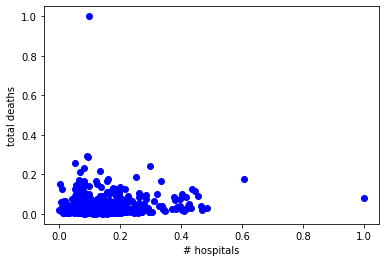

In [25]:
plt.plot(list(combined_data['HospCt']), list(combined_data['normalized_deaths']), 'bo')
plt.xlabel('# hospitals')
plt.ylabel('total deaths')

In [26]:
filter1 = combined_data['Deaths'] > 140
# filter2 = combined_data['deaths'] > 300000
filtered = combined_data.where(filter1)
# filtered.where(filter2, inplace=True)
filtered = filtered.dropna()
filtered.head()

,2wk Prior Mobility,2wk Onset Mobility,2wk Post Mobility,inter_movement,out_movement,baseline m50 mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Deaths,normalized_deaths
FIPS,,,,,,,,,,,,,,,,,,,,,


In [27]:
data_arr = combined_data.to_numpy()
X = data_arr[:,2].reshape(1, -1).T
Y = data_arr[:,3].reshape(1, -1).T
reg = lm.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.2130317667461442

In [28]:
data_arr = combined_data.to_numpy()
X = data_arr[:,2:10].reshape(8, -1).T
Y = data_arr[:,10].reshape(1, -1).T
reg = lm.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.008095441907007839

In [29]:
# combined_data=combined_data.set_index('FIPS')
combined_data.to_csv('../data/intermediates/pre_acpca1.csv')
combined_data.shape

(489, 25)

In [30]:
len(combined_data.columns)

25

In [31]:
print(combined_data.columns[0:20])

Index(['2wk Prior Mobility', '2wk Onset Mobility', '2wk Post Mobility',
       'inter_movement', 'out_movement', 'baseline m50 mobility',
       'Density per square mile of land area - Population',
       'Rural-urban_Continuum Code_2013',
       'Percent of adults with less than a high school diploma 2014-18',
       'Percent of adults with a bachelor's degree or higher 2014-18',
       'Unemployment_rate_2018', 'Med_HH_Income_Percent_of_State_Total_2018',
       'Total_age65plus', 'Total households!!Average household size',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled i

In [32]:
combined_data.head()

,2wk Prior Mobility,2wk Onset Mobility,2wk Post Mobility,inter_movement,out_movement,baseline m50 mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Deaths,normalized_deaths
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,1.57607,0.855816,0.878907,0.519349,0.244188,0.610171,0.001558,0.4,0.229851,0.312698,...,0.129585,0.627997,0.462848,0.038455,0.170836,0.038549,0.116681,0.952015,0.000789,0.010689
1051,1.58923,0.827146,0.482122,0.452205,0.745075,0.840246,0.001753,0.2,0.346269,0.204762,...,0.130406,0.487643,0.645915,0.113909,0.338853,0.021248,0.290098,0.923225,0.000789,0.032762
1055,1.64871,0.871093,0.894249,0.677227,0.378689,0.449395,0.002718,0.4,0.402985,0.096825,...,0.358494,0.567540,0.360599,0.075155,0.261462,0.031866,0.210358,0.689060,0.000986,0.028791
1073,1.61636,0.854042,0.873638,0.775948,0.190299,0.483877,0.008438,0.0,0.247761,0.330159,...,0.386817,0.576102,0.416900,0.172229,0.169115,0.031499,0.594907,0.694818,0.005521,0.013511
1081,1.30818,0.655494,0.697297,0.572121,0.464994,0.307942,0.003231,0.4,0.223881,0.357143,...,0.144048,0.571650,0.442769,0.609583,0.050141,0.029159,0.312716,0.704415,0.003943,0.046459
